# Make a simple pujol test example

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [3]:
import galsim
import autometacal as amc
import tensorflow as tf

In [4]:
stamp_size = 51
batch_size = 1
shear_true = [0.,0.]
true_epsf = [0.,0.]
noise_level = 1e-3
gal_hlr = 0.5
flux = 1.
scale = 0.263
psf_fwhm = 0.7
method = 'auto'
window_fwhm = 1.7

In [5]:
psf_obj = galsim.Moffat(beta=4.8, fwhm=psf_fwhm).shear(g1=true_epsf[0],g2=true_epsf[1])

In [6]:
noise_imgs = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])

In [7]:
intrinsic_shape = [0,0]
obj = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1])

obj = obj.shear(g1=shear_true[0] ,g2=shear_true[1] )
#convolve
obj = galsim.Convolve([obj,psf_obj])
#draw
gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array
psf_image = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=method).array



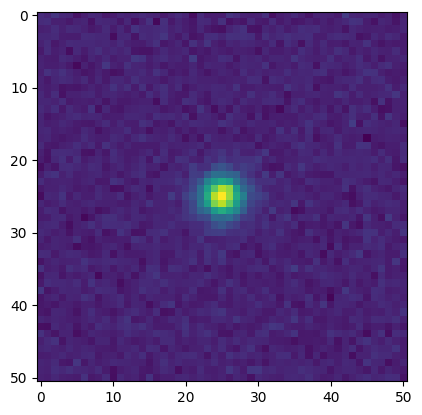

In [8]:
gal_image += noise_imgs[0]
imshow(gal_image)

In [56]:
def method(im):
  im = tf.convert_to_tensor(im.reshape([-1,len(im),len(im)]),dtype=tf.float32)
  return amc.get_moment_ellipticities(im, scale=scale, fwhm=window_fwhm)

In [68]:
method(gal_image)[0] - method(gal_image)[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [20]:
def generate_exponential(shape=[0.,0.],**kwargs):
  options = {
  'gal_hlr' : 0.5,
  'flux' : 1.,
  'method' : 'auto', #pixel integration in GalSim
  'scale': 0.263, #DECam
  }
  options.update(kwargs)
  galaxy = galsim.Exponential(half_light_radius=options['gal_hlr']).shear(g1=shape[0],g2=shape[1])
  
  return galaxy

def generate_kolmogorov(**kwargs):
  options = {
    'psf_fwhm' : 0.7    
  }
  options.update(kwargs)
  
  psf = galsim.Kolmogorov(options['psf_fwhm'])
  
  return psf

In [21]:
generate_kolmogorov(psf_fwhm=.7)

galsim.Kolmogorov(lam_over_r0=0.7, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05))

In [22]:
generate_exponential()

galsim.Transformation(galsim.Exponential(scale_radius=0.2979121736888488, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), jac=[[1.0, 0.0], [0.0, 1.0]], offset=galsim.PositionD(x=0.0, y=0.0), flux_ratio=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05), propagate_gsparams=True)

In [81]:
def pujol(ellip_method,gal_generator,psf_generator,gal_noise_img,psf_noise_img,**kwargs):
  options = {  
  'step': 0.02,
  'psf_fwhm' : 0.7,
  'method' : 'auto',
  'stamp_size' : 51,
  'scale' : 0.263
   
  }
  options.update(kwargs)
  
  #make a real psf
  psf = psf_generator(psf_fwhm=options['psf_fwhm'])
  
  #get some galaxy model
  gal0 = gal_generator()
  
  #shear model with step in each component
  #shear g1
  gal1 = gal0.shear(g1=options['step'],g2=0)
  #shear g2
  gal2 = gal0.shear(g1=0,g2=options['step'])
  
  
  gal0 = galsim.Convolve([gal0,psf])
  gal1 = galsim.Convolve([gal1,psf])
  gal2 = galsim.Convolve([gal2,psf])
  
  #get array from images
  gal0im = gal0.drawImage(nx=options['stamp_size'],ny=options['stamp_size'],scale=options['scale'],method=options['method']).array + gal_noise_img
  gal1im = gal1.drawImage(nx=options['stamp_size'],ny=options['stamp_size'],scale=options['scale'],method=options['method']).array + gal_noise_img 
  gal2im = gal2.drawImage(nx=options['stamp_size'],ny=options['stamp_size'],scale=options['scale'],method=options['method']).array + gal_noise_img
  
  #make an estimation of the psf
  psf_obs = psf.drawImage(nx=options['stamp_size'],ny=options['stamp_size'],scale=options['scale'],method=options['method']).array + psf_noise_img

  #get estimated ellipticities
  print(gal0im.shape)
  g0p = ellip_method(gal0im).numpy()[0]
  g1p = ellip_method(gal1im).numpy()[0]
  g2p = ellip_method(gal2im).numpy()[0]
  

  #return residual R
  R11 = (g1p[0]-g0p[0])/(options['step'])
  R21 = (g1p[1]-g0p[1])/(options['step']) 
  R12 = (g2p[0]-g0p[0])/(options['step'])
  R22 = (g2p[1]-g0p[1])/(options['step'])
  
  Residual = np.array(
    [[R11,R12],
     [R21,R22]])
  
  return Residual

In [83]:
gal_pix_noise = np.random.normal(0,noise_level,size=[stamp_size,stamp_size])
psf_pix_noise = np.random.normal(0,noise_level/10,size=[stamp_size,stamp_size])

In [86]:
pujol(method,generate_exponential,generate_kolmogorov,gal_pix_noise,psf_pix_noise)

(51, 51)


array([[ 7.03647127e-01, -3.30619514e-05],
       [ 1.42026693e-05,  7.03713903e-01]])

In [ ]:
galsimrot90 = galsim.Angle(90,galsim.AngleUnit(np.pi/180.))

def make_noise(noise_level,batch_size,stamp_size):
  '''make a simple gaussian noise stamp'''
  noise_imgs = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  return noise_imgs

def observer(batch_size=25, 
             shear_true = [0.,0.] ,
             true_epsf = [0.,0.], 
             noise_level = 1e-6,
             shape_noise = False,
             symmetric = True, **kwargs):
  '''creates observations for ngmix and amc'''
  
  #galaxy intrinsic properties
  options = {
  'gal_hlr' : 0.5,
  'flux' : 1.,
  'psf_fwhm' : 0.7,
  'method' : 'auto'  
  }
  options.update(kwargs)
  #psf properties
  psf_obj = galsim.Moffat(beta=4.8, fwhm=options['psf_fwhm']).shear(g1=true_epsf[0],g2=true_epsf[1]) 
  psf_images_list = []
  gal_images_list = []
  method ='auto'
  for i in range(batch_size):
    #intrinsic shape
    intrinsic_shape = [0,0] #for the future, add shape noise
    
    obj = galsim.Exponential(half_light_radius=options['gal_hlr']).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1])
    #shear
    obj = obj.shear(g1=shear_true[0] ,g2=shear_true[1] )
    #convolve
    obj = galsim.Convolve([obj,psf_obj])
    #draw
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=options['method']).array
    psf_image = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=options['method']).array
    
    psf_images_list += [psf_image]
    gal_images_list += [gal_image]
  
  psf_images = tf.convert_to_tensor(np.array(psf_images_list),dtype=tf.float32)
  gal_images = tf.convert_to_tensor(np.array(gal_images_list),dtype=tf.float32)
  
  #add noise
  noise_images = make_noise(noise_level,batch_size,stamp_size)
  gal_images += noise_images
  
  #add noise to the psf model after convolution to make it an observed model
  psf_noise_images = make_noise(psf_noise_level,batch_size,stamp_size)
  psf_images += psf_noise_images
    
  #images to be used for fixnoise are different from the
  #actual noise, but with the same level
  noise_images_out = make_noise(noise_level,batch_size,stamp_size)
  
  if symmetric:
    
    psf_images90_list = []
    gal_images90_list = []
    for i in range(batch_size):
      #intrinsic shape
      intrinsic_shape = [0,0] #for the future, add shape noise
      
      obj90 = galsim.Exponential(half_light_radius=options['gal_hlr']).shear(g1=intrinsic_shape[0],g2=intrinsic_shape[1]).rotate(galsimrot90)
      #shear
      obj90 = obj90.shear(g1=shear_true[0] ,g2=shear_true[1])
      #convolve
      obj90 = galsim.Convolve([obj90,psf_obj])
      #draw
      gal_image90 = obj90.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=options['method']).array
      psf_image90 = psf_obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale,method=options['method']).array

      psf_images90_list += [psf_image90]
      gal_images90_list += [gal_image90]

    psf_images90 = tf.convert_to_tensor(np.array(psf_images90_list),dtype=tf.float32)
    gal_images90 = tf.convert_to_tensor(np.array(gal_images90_list),dtype=tf.float32)
   
    #add noise
    noise_images90 = make_noise(noise_level,batch_size,stamp_size)
    gal_images90 += noise_images90
    
    #add noise to the psf model
    psf_noise_images90 = make_noise(psf_noise_level,batch_size,stamp_size)
    psf_images90 += psf_noise_images90
    
    #images to be used for fixnoise are different from the
    #actual noise, but with the same level
    noise_images_out90 = make_noise(noise_level,batch_size,stamp_size)
    
    #concatenate symmetrised obs
    gal_images= np.concatenate([gal_images,gal_images90])
    psf_images = np.concatenate([psf_images,psf_images90])
    noise_images_out = np.concatenate([noise_images_out,noise_images_out90])
  
  #generate observations for ngmix
  obslist = []
  import ngmix
  for im, psf_im in zip(gal_images,psf_images):
    cen = (np.array(im.shape))//2
    psf_cen = (np.array(psf_im.shape))//2

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0], col=cen[1], scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return gal_images, psf_images ,noise_images_out, obslist